<a href="https://colab.research.google.com/github/Ziad-o-Yusef/Vision-Transformers-Code/blob/main/GEOEYE_70_Training_Transformers_phase_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install split-folders
! pip install datasets
! pip install accelerate -U
! pip install transformers[torch]
! pip show transformers
! pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive

import datasets
import torch

from datasets import load_metric
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Data_path = '/content/drive/MyDrive/GEOEYE-70 '
print(os.listdir(Data_path))

['stadium', 'terrace', 'transmission_tower', 'swimmimg_pool', 'Water_bodies', 'storage_tank', 'vegetable_greenhouse', 'tennis_court', 'wetland', 'wind_turbine', 'shipping_yard', 'runway', 'sparse_residential_area', 'square', 'Sea2_Frist_year_Ice', 'school', 'snowberg', 'Sea3_Young_Ice', 'SeaLake', 'Sea1_Old_Ice', 'river', 'roundabout', 'parking_lot', 'parkway', 'pond', 'PermanentCrop', 'Pasture', 'railway', 'railway_station', 'resort', 'mediumresidential_', 'lake', 'Isbergs_Glacier', 'mountain', 'island', 'park', 'overpass', 'mobile_home_park', 'meadow', 'intersection', 'IndustrialPuldings', 'Icebergs', 'Industrial Area', 'golf_course', 'forest', 'freeway', 'Highway', 'harbor&port', 'ground_track_field', 'HerbaceousVegetation', 'eroded_farmland', 'commercial_area', 'farmland', 'Floating_ice', 'cloud', 'center', 'buildings', 'dense_residential_area', 'chaparral', 'desert', 'airport', 'agricultural', 'bareland', 'basketball_court', 'beach', 'bridge', 'AnnualCrop', 'baseball diamond', 'ai

In [ ]:
imshow_dirs = []

In [ ]:

dir = Data_path
dirs = os.listdir(dir)

for i in dirs :
    step = os.listdir(dir+ '/'+ i)
    imshow_dirs.append(dir+ '/' + i + '/' + step[1])
print(len(imshow_dirs))

138


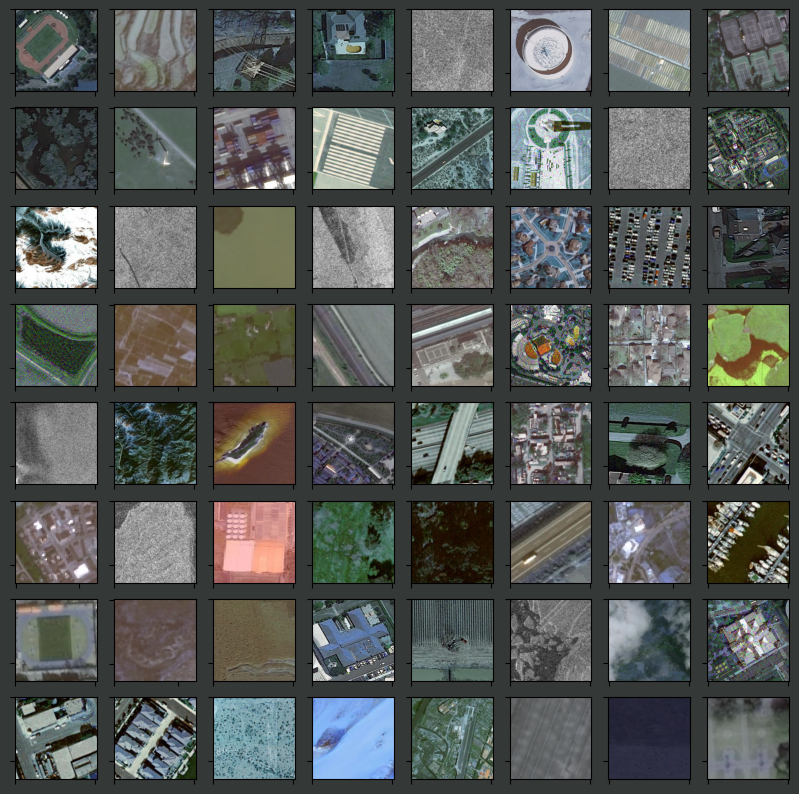

In [ ]:
fig, ax = plt.subplots(8,8,figsize=(10,10),facecolor='#343837')
for n in range(8):
    for m in range(8):
        path =imshow_dirs[m + 8*n]
        image = cv2.imread(str(path))
        ax[n,m].set_xticklabels([])
        ax[n,m].set_yticklabels([])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [ ]:
import splitfolders
splitfolders.ratio(Data_path, output="output", seed=1337, ratio=(.8, 0.2,))

Copying files: 34600 files [11:45, 49.06 files/s]


In [ ]:
New_dp = '/content/output'
os.listdir(New_dp)

['val', 'train']

In [ ]:
len(os.listdir('/content/output/train'))

69

In [ ]:
(len(os.listdir('/content/output/train/AnnualCrop'))),(len(os.listdir('/content/output/val/AnnualCrop')))

(400, 100)

In [ ]:
(len(os.listdir('/content/output/train/Isbergs_Glacier'))),(len(os.listdir('/content/output/val/Isbergs_Glacier')))

(400, 100)

In [ ]:
" Modiling Functions "

def model_processor(model_name,Vit_or_Auto):
  if Vit_or_Auto == 'vit':
    processor = ViTImageProcessor.from_pretrained(model_name)
    return processor
  elif Vit_or_Auto ==  'auto':
    processor =  AutoImageProcessor.from_pretrained(model_name)
    return processor


def transform(data):
    inputs = processor([x for x in data['image']], return_tensors='pt')

    inputs['labels'] = data['label']
    return inputs


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


def Model(model_name,num_labels,id2label,label2id,WithInfo,Vit_or_Auto):
  if Vit_or_Auto == 'vit':
    if WithInfo:
      return  ViTForImageClassification.from_pretrained(
      model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,)
    else:
      return  ViTForImageClassification.from_pretrained(
      model_name,)
  elif Vit_or_Auto == 'auto':
    return AutoModelForImageClassification.from_pretrained(model_name)


def training_args(output_dir,num_train_epochs):

    return TrainingArguments(
  output_dir=output_dir,
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs= num_train_epochs,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  #report_to='tensorboard',
  load_best_model_at_end=True)


metric = load_metric("accuracy")
def compute_metrics(p):
  return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


def Training_func(model,training_args,collate_fnm,compute_metrics,train_dataset,eval_dataset,tokenizer):
    return Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

<ipython-input-10-8c919b36ded3>:59: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
train_dataset = datasets.load_dataset("imagefolder", data_dir="/content/output/train")
test_dataset = datasets.load_dataset("imagefolder", data_dir="/content/output/val")

Resolving data files:   0%|          | 0/27680 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/6920 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27680
    })
})

In [ ]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6920
    })
})

In [ ]:
processor = model_processor('google/vit-base-patch16-224-in21k','vit')

train_ds = train_dataset.with_transform(transform)
test_ds = test_dataset.with_transform(transform)


labels = os.listdir('/content/output/train')
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}

google_model = Model('google/vit-base-patch16-224-in21k',len(labels),id2label,label2id,True,'vit')

google_model_training_args = training_args("/content/sample_data",5)

training_cat = Training_func(google_model,google_model_training_args,collate_fn,compute_metrics
                             ,train_ds['train'],test_ds['train'],processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results_4 = training_cat.train()
training_cat.log_metrics("train", train_results_4.metrics)
training_cat.save_metrics("train", train_results_4.metrics)
training_cat.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,2.764500,2.709793,0.590318
200,1.660900,1.618687,0.752023
300,0.909000,1.161266,0.772832
400,0.839900,0.804213,0.828757
500,0.796500,0.657097,0.836272
600,0.459800,0.545415,0.861127
700,0.707900,0.548667,0.854624
800,0.386000,0.418510,0.887861
900,0.512200,0.475274,0.869075
1000,0.392900,0.446063,0.875145


***** train metrics *****
  epoch                    =          5.0
  total_flos               = 9994331428GF
  train_loss               =       0.2204
  train_runtime            =   2:17:13.35
  train_samples_per_second =        16.81
  train_steps_per_second   =        1.051


In [ ]:
metrics = training_cat.evaluate(test_ds['train'])
training_cat.log_metrics("eval", metrics)
training_cat.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9717
  eval_loss               =     0.1259
  eval_runtime            = 0:01:05.98
  eval_samples_per_second =    104.865
  eval_steps_per_second   =     13.108


In [ ]:
processor = model_processor('facebook/deit-small-patch16-224','vit')

train_ds = train_dataset.with_transform(transform)
test_ds = test_dataset.with_transform(transform)

labels = os.listdir('/content/output/train')
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}

facebook_model = Model('facebook/deit-small-patch16-224',len(labels),id2label,label2id,False,'vit')
facebook_model_args = training_args("./vit-task_2",5)

training_cat = Training_func(facebook_model,facebook_model_args,collate_fn,compute_metrics
                             ,train_ds['train'],test_ds['train'],processor)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
facebook_train_results = training_cat.train()
training_cat.log_metrics("train", facebook_train_results.metrics)
training_cat.save_metrics("train", facebook_train_results.metrics)
training_cat.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,1.787600,1.687720,0.532659
200,1.167200,1.126378,0.655202
300,0.663700,1.140958,0.680636
400,0.740400,0.768415,0.766185
500,0.940900,0.713992,0.786272
600,0.479000,0.650465,0.807803
700,0.590900,0.550828,0.824277
800,0.515300,0.577071,0.817197
900,0.469200,0.555080,0.830491
1000,0.473900,0.518309,0.837428


***** train metrics *****
  epoch                    =          5.0
  total_flos               = 2567003339GF
  train_loss               =       0.2132
  train_runtime            =   1:40:54.79
  train_samples_per_second =       22.858
  train_steps_per_second   =        1.429


In [ ]:
metrics = training_cat.evaluate(test_ds['train'])
training_cat.log_metrics("eval", metrics)
training_cat.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9682
  eval_loss               =     0.1407
  eval_runtime            = 0:00:53.70
  eval_samples_per_second =    128.857
  eval_steps_per_second   =     16.107


In [ ]:
processor = model_processor('microsoft/beit-base-patch16-224-pt22k-ft22k','auto')

train_ds = train_dataset.with_transform(transform)
test_ds = test_dataset.with_transform(transform)

labels = os.listdir('/content/output/train')
id2label={str(i): c for i, c in enumerate(labels)}
label2id={c: str(i) for i, c in enumerate(labels)}

model_4 = Model('microsoft/beit-base-patch16-224-pt22k-ft22k',len(labels),id2label,label2id,False,'auto')
model_4_training_args = training_args("./vit-task_2",5)

training_cat = Training_func(model_4,model_4_training_args,collate_fn,compute_metrics
                             ,train_ds['train'],test_ds['train'],processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results_4 = training_cat.train()
training_cat.log_metrics("train", train_results_4.metrics)
training_cat.save_metrics("train", train_results_4.metrics)
training_cat.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,2.768600,2.655310,0.303324
200,1.945000,1.788004,0.499855
300,1.259600,1.677685,0.544364
400,1.141400,1.240888,0.654769
500,1.096500,1.117163,0.678035
600,1.070600,0.857770,0.741040


Checkpoint destination directory ./vit-task_2/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Step,Training Loss,Validation Loss,Accuracy
100,2.768600,2.655310,0.303324
200,1.945000,1.788004,0.499855
300,1.259600,1.677685,0.544364
400,1.141400,1.240888,0.654769
500,1.096500,1.117163,0.678035
600,1.070600,0.857770,0.741040
700,0.936700,0.930647,0.723410
800,0.797300,0.812387,0.769220
900,0.826100,0.761227,0.759682
1000,0.753400,0.741146,0.770376


Checkpoint destination directory ./vit-task_2/checkpoint-8600 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =           5.0
  total_flos               = 11939141232GF
  train_loss               =        0.3445
  train_runtime            =    2:23:01.41
  train_samples_per_second =        16.128
  train_steps_per_second   =         1.008


In [ ]:
metrics = training_cat.evaluate(test_ds['train'])
training_cat.log_metrics("eval", metrics)
training_cat.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9663
  eval_loss               =     0.1551
  eval_runtime            = 0:01:08.31
  eval_samples_per_second =      101.3
  eval_steps_per_second   =     12.663
